# Introducción
Se desea profundizar la comprensión del funcionamiento de la capa de red, y cómo esta permite establecer una conexión con otras computadoras en un mismo router. Se conoce que, especialmente en un ambiente tal como la Universidad, una gran cantidad de dispositivos se encuentran conectados al mismo router en un momento dado. Estos equipos se comunican entre sí a través de las subredes que crea el router, permitiendo una comunicación entre estos. Por supuesto, para el funcionamiento de estos equipos con los protocolos existentes de comunicación, es necesario que el router le asigne una dirección IP local a cada uno de ellos. A su vez, cada una de las computadoras debe identificarse de una manera única, y lo realiza con la dirección MAC (medium access control) de su tarjeta de red.

Con estas condiciones en mente, se aprovecha el protocolo ARP. El protocolo ARP, o address resolution protocol, es un protocolo que se utiliza para determinar las asociaciones entre IP y MAC que actualmente existen en la red. Para esto, cada computadora posee una tabla donde se especifica cada dirección IP, cada dirección MAC, y su tiempo de vida. Al utilizar este protocolo, se puede hacer un llamado al enrutador para construir esta tabla. Esto permite, a través de la modificación de los datos que ingresan, obtener la información de todos los dispositivos que tienen su tarjeta de red conectada actualmente al router donde se está corriendo el programa. A su vez, es necesario recordar que la IEEE es la que otorga los MAC a cada proveedor, por lo que a tráves de estos se puede determinar los fabricantes de las tarjetas de red de las computadoras. A pesar de que Windows funciona en una gran variedad de softwares, se tiene una idea general de qué fabricantes proveen el hardware para los equipos que usan este sistema operativo. Con esta recopilación de datos, se puede obtener las proporciones de estos fabricantes, y analizarlos de una manera más profunda.

# Metodología
Para la realización del proyecto, se utilizó el lenguaje de Python. Además, se procedió a utilizar y modificar el script ``dr_arp_discovery.py``, desarrollado por el doctor Daniel Riofrio, PhD, para realizar la llamada al protocolo ARP y la recopilación de los datos de las direcciones MAC de las computadoras.

1. Se desarrolló una serie de pruebas para realizar el correcto funcionamiento del script
    * Se realizó estas pruebas con los siguientes métodos
        * Windows en bare-metal
        * Linux en virtual machine
        * Linux en bare metal
    * Se determinó que el mejor funcionamiento era en Windows en bare-metal
2. Se procedió a modificar el programa para corregir la recopilación de direcciones MAC
    * Se descubrió que el script actual tenía una problemática al buscar direcciones MAC
    * Se buscaba el source en vez del hardware source
3. Se modificó el programa para obtener el output deseado
    * Se imprimió el programa determinando si la red era LAN o WAN
    * Se imprimió además la fecha y hora para realizar el muestreo
    * Se imprimió los pares del hardware source con el IP 
4. Se tomó los datos en tiempo real
    * Esto se realizó en el edificio de Registro de la Universidad San Francisco de Quito
    * Se realizó en distintas horas
    * Se realizó con distintos time-outs para el programa

# Análisis de resultados
Una vez tomados los datos, se procede a estudiarlos de forma separada: LAN y WLAN. Se espera que la cantidad de datos tomados mediante una conexión Ethernet sea mayor que una conexión Wi-Fi por la cantidad limitada de puertos Ethernet en la universidad en comparación con el número de usuarios que se conectan a través de Wi-Fi a la red.

El siguiente bloque de código lee los archivos producidos por el script ``dr_arp_discovery.py`` y los organiza en dos listas, una para los datos tomados en LAN, y otra para datos tomados en WLAN.

In [30]:
import os
import pandas as pd
from matplotlib import pyplot as plt

directory = 'results'

files = os.listdir(directory)

information_LAN = []
information_WLAN = []

for file in files:
    with open(directory+'/'+file) as f:
        try:
            while f.readable():
                line = f.readline()
                line = line.split('\t')
                if 'WLAN' in file:
                    information_WLAN.append((line[0], line[1], line[2].strip('\n')))
                else:
                    information_LAN.append((line[0], line[1], line[2].strip('\n')))
        except:
            pass

### LAN
Antes de graficar y analizar los datos es necesario depurarla, pues durante las tres instancias de toma de datos aparecen algunas direcciones MAC repetidas. Se desea ver cuántas direcciones MAC únicas se encuentran en total en esta red. La dirección IP estática del puerto utilizado (esquina en la zona de registro del Galileo) es ``172.21.25.126`` con la máscara de red ``24``.

Total number of MAC addresses:  44


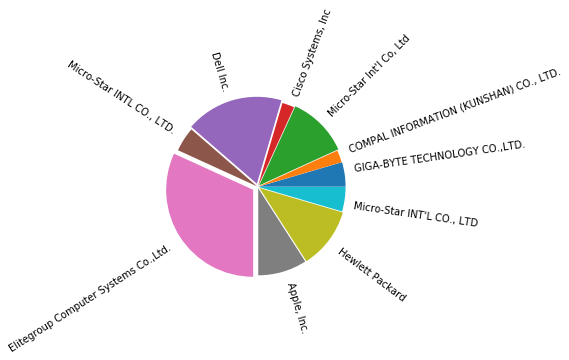

In [63]:
dataframe = pd.DataFrame(information_LAN, columns=['IP', 'MAC', 'Vendor'])

# Se remueven las MAC addresses repetidas para tener solo dispositivos únicos.
dataframe.drop_duplicates('MAC', inplace=True)

total = len(dataframe)
vendors = set(dataframe.Vendor)
proportions = []
explosions = []

for v in vendors:
    p = 0
    for vd in dataframe.Vendor:
        if vd == v:
            p += 1
    proportions.append(p)
    explosions.append(p/total/5)
print("Total number of MAC addresses: ", total)
plt.pie(proportions, explode=explosions, labels=vendors, rotatelabels=True);

In [49]:
dataframe.drop(columns=['IP']).groupby('Vendor').count()/total*100

,MAC
Vendor,
"Apple, Inc.",9.090909
"COMPAL INFORMATION (KUNSHAN) CO., LTD.",2.272727
"Cisco Systems, Inc",2.272727
Dell Inc.,18.181818
"Elitegroup Computer Systems Co.,Ltd.",31.818182
"GIGA-BYTE TECHNOLOGY CO.,LTD.",4.545455
Hewlett Packard,11.363636
"Micro-Star INT'L CO., LTD",4.545455
"Micro-Star INTL CO., LTD.",4.545455


Visiblemente, el fabricante que se muestra en mayor proporción en la red LAN es Elitegroup Computer Systems (ECS) con ``31.81%``. Se debe notar que al momento de obtener los fabricantes de las direcciones MAC se obtiene una misma marca de proveedor de tarjeta de red tres veces pero con diferente formato de string: Micro-Star INT´L CO. LTD (MSI), siendo el porcentaje total ``20.45%``.

ECS fabrica sus propias mini PCs llamadas LIVA Q, las cuales contienen todos los puertos principales de una desktop, incluyendo el puerto para Ethernet, el RJ45 (Elitegroup Computer Systems, s/f). Interesantemente, no se pudo encontrar en internet la tarjeta NIC fabricada por ECS en venda individual, de modo que se asume que las direcciones MAC que corresponden a este fabricante son de LIVA Q's instalados en el campus. MSI sí vende sus NICs de forma individual y provee un amplio rango de variantes, por lo que no se puede precisar  qué tipo o marca de desktops (o incluso laptops) se conectan a esta red, pero es válido asumir que una proporción de estos son efectivamente desktops.

### WLAN
De igual forma que con los datos LAN, se depuran las direcciones MAC repetidas. Las direcciones IP desde las cuales se tomaron los datos para WLAN son: ``172.21.184.140``, ``172.21.184.142``, y ``172.21.184.116``, todas con máscara de red ``21``. Es interesante recalcar que la máscara de la red wireless es ``21``, lo cual permite un límite de 2048 dispositivos conectados a esta red a la vez (sin contar las dos direcciones reservadas que terminan en ``.0`` y ``.255``) a diferencia de la máscara ``24`` que permite hasta 256 dispositivos. La variación del último campo de las IPs se da porque la asignación de IPs se hace de forma dinámica desde el punto de acceso Wi-Fi a medida que dispositivos se conectan y desconectan, y la toma de datos se hizo con una diferencia de tiempo de al menos 2 horas.

Total number of MAC addresses:  174


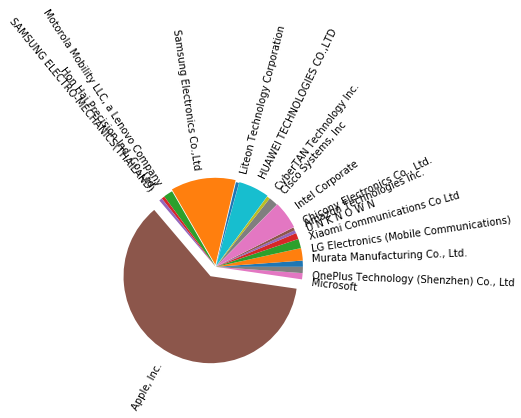

In [64]:
dataframe = pd.DataFrame(information_WLAN, columns=['IP', 'MAC', 'Vendor'])

# Se remueven las MAC addresses repetidas para tener solo dispositivos únicos.
dataframe.drop_duplicates('MAC', inplace=True)

total = len(dataframe)
vendors = set(dataframe.Vendor)
proportions = []
explosions = []

for v in vendors:
    p = 0
    for vd in dataframe.Vendor:
        if vd == v:
            p += 1
    proportions.append(p)
    explosions.append(p/total/5)
print("Total number of MAC addresses: ", total)
plt.pie(proportions, explode=explosions, labels=vendors, rotatelabels=True);

In [56]:
dataframe.drop(columns=['IP']).groupby('Vendor').count()/total*100

,MAC
Vendor,
Amazon Technologies Inc.,0.574713
"Apple, Inc.",61.494253
"Chicony Electronics Co., Ltd.",0.574713
"Cisco Systems, Inc",1.724138
CyberTAN Technology Inc.,0.574713
"HUAWEI TECHNOLOGIES CO.,LTD",5.747126
"Hon Hai Precision Ind. Co.,Ltd.",0.574713
Intel Corporate,5.172414
LG Electronics (Mobile Communications),2.298851


Se puede notar que la obvia mayoría de dispositivos pertenecen a Apple Inc con ``61.49%`` de presencia, seguido por Samsung Electronics con ``12.06%``, y seguido por Huawei Technologies en ``5.74%``. Se puede especular que estas proporciones corresponden a la cantidad de usuarios de dispositivos móviles de dichas marcas con su respectiva popularidad de uso. Es necesario recalcar que varios de estos dispositivos pueden representar laptops y computadoras conectadas inalámbricamente (incluyendo computadoras Apple).

Interesantemente existen dos direcciones MAC que no pueden ser identificadas con un proveedor. Existen muchas posibilidades para explicar esto: una razón podría ser que esta dirección MAC está registrado confidencialmente con la IEEE, lo cual es un servicio que incurre en un costo adicional al registro de la dirección MAC (IEEE, s/f). Otra posible razón es que estas direcciones hayan sido objeto de spoofing, lo cual implica modificar el códico de la MAC en el dispositivo para hacerlo irreconocible, lo cual es un proceso relativamente fácil (Cárdenas, 2003).

# Conclusiones
El estudio de las direcciones MAC asociadas con direcciones IPs permite visualizar la proporción de marcas de dispositivos existentes en el campus de la USFQ. Existe la noción en los usuarios de dispositivos conectados a la red de que están aislados en su conexión al internet, pero la realidad es que toda la información que envían y reciben puede ser monitoreada por cualquier otro dispositivo conectado a la misma red. Esto significa que el nivel de privacidad que un usuario tiene dentro de la red es limitado, y existe la posibilidad de interceptar esta información de forma maliciosa. Sin embargo, muchos protocolos web toman esta noción en cuenta y la resuelven mediante conecciones encriptadas, como HTTPS por ejemplo. Otro aspecto curioso del uso del protocolo ARP es el hallazgo de direcciones MAC sin proveedor reconocible, pues esto corresponde a un dispositivo no convencional conectado a la red. Sin conocer el origen de estas direcciones MAC, se puede decir que lo más probables es que no hayan sido cambios arbitrarios de dirección y que existe un motivo humano para alterar o confidencializar el identificador de sus dispositivos.

# Referencias
* Elitegroup Computer Systems. (s/f). *LIVA Q*. Extraído de: https://www.ecs.com.tw/ECSWebSite/Product/Product_Overview/EN/System/LIVA%20Q/LIVA
* IEEE. (s/f). *MAC Address Block Large MA-L*. Extraído de: https://standards.ieee.org/products-services/regauth/oui/index.html
* Cardenas, Edgar D. (2003) *MAC Spoofing--An Introduction*. GIAC Security Essentials Certification. SANS Institute. Extraído de: https://www.giac.org/paper/gsec/3199/mac-spoofing-an-introduction/105315